<a href="https://colab.research.google.com/github/preetham-v/GameTheory2019/blob/master/antiviral_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/preetham-v/antiviralGAN/master/AVPdb_data.csv'

data = pd.read_csv(url, skiprows = 1, usecols = range(3), header=None, names=['ID','seq','len'])

In [3]:
all_sequences = np.asarray(data['seq'])
print(all_sequences[:5])

['PYVGSGLYRR' 'SMIENLEYM' 'ECRSTSYAGAVVNDL' 'STSYAGAVVNDL' 'YAGAVVNDL']


In [4]:
#Dictionary of 20 canonical amino acids
CHARACTER_DICT = set([
    u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K',
    u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W',
    u'V', u'Y']
)

CHARACTER_TO_INDEX = {
    character: i
    for i, character in enumerate(CHARACTER_DICT)
}

INDEX_TO_CHARACTER = {
    CHARACTER_TO_INDEX[c]: c
    for c in CHARACTER_TO_INDEX
}

In [5]:
MAX_SEQUENCE_LENGTH = 18 #Problem Statement requires < 2000 kDa, Avg. amino acid = 110 kDa
num_amino_acids = len(CHARACTER_DICT) 

In [6]:
def sequence_to_vector(sequence, embed_dict=None):
    if embed_dict==None:
        default = np.zeros([MAX_SEQUENCE_LENGTH, len(CHARACTER_TO_INDEX)+1])
        default[:,len(CHARACTER_TO_INDEX)] = 1
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            default[i][CHARACTER_TO_INDEX[character]] = 1
            default[i][len(CHARACTER_TO_INDEX)] = 0
        return default
    else:
        default = np.zeros([MAX_SEQUENCE_LENGTH,len(embed_dict['A'])])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            for k,val in enumerate(embed_dict[character]):
                default[i,k] = val
        return default

In [7]:
def vector_to_sequence(vector):
    seq = ''

    for i in range(18):
        arg = np.argmax(vector[i])
        if arg == 20:
          seq += 'X'
        else:
          seq += INDEX_TO_CHARACTER[arg]
    return seq


In [8]:
class Generator(nn.Module):
    def __init__(self, input_length):
        """A generator for mapping a random peptide to an antiviral peptide
        Args:
            input_length (int array): max_length * number_of_characters 
                                      ("noise vector")
            layers (List[int]): A list of layer widths including output width
            output_activation: torch activation function or None
        """
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(input_length, 40)
        self.leaky_relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(40, 120)
        self.linear3 = nn.Linear(120, 240)
        self.linear4 = nn.Linear(240, 378)
        self.output_activation = nn.LeakyReLU()

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = self.linear1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear3(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear4(intermediate)
        intermediate = self.output_activation(intermediate)

        view = intermediate.view(-1, 18)
        (view == view.max(dim=1, keepdim=True)[0]).view_as(intermediate).int()
        
        return intermediate

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, layers):
        """A discriminator for discerning real from generated samples.
        params:
            input_dim (int): width of the input
            layers (List[int]): A list of layer widths including output width
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
            else:
                self.module_list.append(nn.Sigmoid())

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

In [10]:
all_inputs = []
for j in range(len(all_sequences)):
  embedding = sequence_to_vector(all_sequences[j])
  all_inputs.append(np.reshape(embedding,378))

In [11]:
def data_function(batch_size, iteration):
  input_array = all_inputs[batch_size*iteration : batch_size*(iteration+1)]
  return input_array

def noise_function(batch_size):
  input_array = []  
  for j in range(batch_size):
    # a = np.zeros([18,21])
    # for i in range(18):
    #   x = np.random.randint(21)
    #   a[i][x] = 1
    # input_array.append(np.reshape(a,378))
    input_array.append(np.random.randn(1,20))

  return input_array

In [ ]:
#@title
class VanillaGAN():
    def __init__(self, generator, discriminator, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = generator
        self.generator = self.generator.to(device)
        self.discriminator = discriminator
        self.discriminator = self.discriminator.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_d = self.train_step_discriminator()
        loss_g = self.train_step_generator()
        return loss_g, loss_d

In [12]:
def simpleGAN(generator_func, discriminator_func, 
              batch_size: int = 25, epochs: int = 5, 
              max_data: int = len(all_sequences), print_every: int = 10, ):

  #Array to monitor losses
  loss_g = []
  loss_dreal = []
  loss_dfake = []
  input_length = 20

  # Models
  generator = generator_func
  discriminator = discriminator_func

  # Optimizers
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                          lr=0.0001)

  # loss
  loss = nn.BCELoss()

  for i in range(epochs):

    for j in range(int(max_data/batch_size)):

      # zero the gradients on each iteration
      generator_optimizer.zero_grad()


      # Create noisy input for generator
      # Need float type instead of int
      noise = noise_function(batch_size)
      noise_data = torch.tensor(noise).float()
      generated_data = generator(noise_data)  

      # Generate examples of real data
      true_data = data_function(batch_size, j)
      true_labels = torch.tensor(np.ones(batch_size)).float()
      true_data = torch.tensor(true_data).float()

      # Train the generator
      # We invert the labels here and don't train the discriminator because we want the generator
      # to make things the discriminator classifies as true.
      generator_discriminator_out = discriminator(generated_data)
      generator_loss = loss(generator_discriminator_out, true_labels)
      generator_loss.backward()
      generator_optimizer.step()

      # Train the discriminator on the true/generated data
      discriminator_optimizer.zero_grad()
      true_discriminator_out = discriminator(true_data)
      true_discriminator_loss = loss(true_discriminator_out, true_labels)

      # add .detach() here think about this
      generator_discriminator_out = discriminator(generated_data.detach())
      generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
      discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2   
      discriminator_loss.backward()
      discriminator_optimizer.step()

      loss_g.append(generator_loss.detach().numpy())
      loss_dreal.append(true_discriminator_loss.detach().numpy())
      loss_dfake.append(generator_discriminator_loss.detach().numpy())
  

    if i % print_every == 0 and i != 0:
      generated_data = generated_data.detach().numpy()
#      x = random.randint(0,len(generated_data))
      sequences = set()
      noises = []
      for j in range(batch_size):
#        noise_var = np.reshape(noise[j], [18,21])
        sequence = np.reshape(generated_data[j], [18,21])
        sequences.add(vector_to_sequence(sequence))
        noises.append(noise[j])
      
#      print(i, noises)
      print(i, sequences)

  return loss_g, loss_dreal, loss_dfake



In [ ]:
#@title Default title text
def main():
    from time import time
    epochs = 600
    batches = 10
    generator = Generator(360)
    discriminator = Discriminator(1, [64, 32, 1])
    noise_fn = noise_function()
    data_fn = data_function()
    gan = VanillaGAN(generator, discriminator, noise_fn, data_fn, device='cpu')
    loss_g, loss_d_real, loss_d_fake = [], [], []
    start = time()
    for epoch in range(epochs):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch in range(batches):
            lg_, (ldr_, ldf_) = gan.train_step()
            loss_g_running += lg_
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
        loss_g.append(loss_g_running / batches)
        loss_d_real.append(loss_d_real_running / batches)
        loss_d_fake.append(loss_d_fake_running / batches)
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" Dr={loss_d_real[-1]:.3f},"
              f" Df={loss_d_fake[-1]:.3f}")


if __name__ == "__main__":
    main()

In [13]:
import time
start_time = time.time()

generator = Generator(20)
discriminator = Discriminator(378, [32, 16, 1])  

losses = simpleGAN(generator, discriminator, 
                   batch_size=2059, epochs=10001, print_every = 100)

print("Program took", time.time() - start_time, "to run")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2059])) that is different to the input size (torch.Size([2059, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2059])) that is different to the input size (torch.Size([2059, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


100 {'FMQKLLNARPAMAHSIYL'}
200 {'ECQYNAGXMPNTWVEMAC'}
300 {'VAHPDAGXKPNTGVEQHC', 'VAHPRAGXKPNTGVEQHC'}
400 {'VAKPVAGXKPNTEFELHC', 'VAKPVAGXKANTEFEQHC', 'VAKPVAGXKPNTEFEQHC', 'VAKPVAGXKANTEFELHC'}
500 {'FRKPGAGXAAQDEQKLGC', 'FRKPGAGXAAQDEQKLHC', 'FRKPGAGXAAQDEQELHC'}
600 {'FKRPRIGXVCNIVQLLQC', 'FKRPXIHXVCNIVQLLQC', 'FKRPXIGXVCNIVQLLQC'}
700 {'IKISRGRSCIPXMLHKEN'}
800 {'PKRSRGXCWIPWMRHKEX', 'PKRSRGXCWIPXMRVKEX', 'IKRSRGXCDINXVRRXEX', 'IKRSRGRSVINXVRRKEX', 'PKRSRGXCWIPWVRHKEX', 'IKRPRGGCVINXVRRXEC', 'IKRSRGXCDIPXMRRKEX', 'IKRSRGXCDIPXVRRXEX', 'IKRPRGGCVINXVRRXEX', 'IKRSRGGCKINXVRRXEX', 'PKRSRGXCWIPWVLHKEX', 'IKRPRGXSAINXMRRXEX', 'IKRSRGXCAINXMRRXEX', 'IKRSRGXCVINXVRRXEX', 'IKRSRGXCAIPXMRVKEX', 'IKRSRGRSVINXVRRXEX', 'PKRSRGXCAIPXMRRKEX', 'IKRPRGGCKINXVRRXEX', 'IKRPRGGXAINXVRRXEC', 'PKRSRGXCWIPWYRVKEX', 'IKRSRGXCWIPXVRHKEX', 'IKRSRGXSVINXVRRKEX', 'IKRSRGXCDIPXMRHKEX', 'IKRPRGGXKINXVRRXEX', 'IKRSRGRCDIPXVRHKEX', 'IKRSRGXCWIPXMRRKEX', 'IKRPRGGXKINXGRRXEC', 'IKRPRGGXVINXVRRXEC', 'IKRSRGXCVIPXM

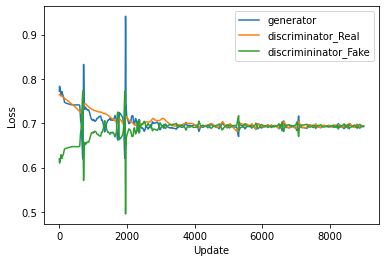

In [16]:
loss_g = losses[0]
loss_dreal = losses[1]
loss_dfake = losses[2]
plt.plot(loss_g[1000:], label = 'generator')
plt.plot(loss_dreal[1000:], label ='discriminator_Real')
plt.plot(loss_dfake[1000:], label = 'discrimininator_Fake')
plt.xlabel('Update')
plt.ylabel('Loss')
plt.legend()

In [269]:
noise = noise_function(5)
noise_data = torch.tensor(noise).float()
generated_data = generator(noise_data)

generated_data = torch.reshape(generated_data, [5,18,21])

generated_data = generated_data.detach().numpy()

sequences = []

for j in range(5):

  sequence = np.reshape(generated_data[j], [18,21])
  sequences.append(vector_to_sequence(sequence))

print(sequences)

['SWDCTMWGHRTCGTTKAR', 'SWDCTMWGHRTCGTTKAR', 'SWDCTMWGHRTCGTTKAR', 'SWDCTMWGHRTCGTTKAR', 'SWDCTMWGHRTCGTTKAR']
